In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'

# Read Data

In [2]:
def file_reader(basedir, filename):
    if filename.endswith('.csv'):
        try:
            df = pd.read_csv(basedir + filename, header=15)
        except:
            df = pd.read_csv(basedir + filename, encoding='euc-kr', header=15)
    elif filename.endswith('.xlsx'):
        try:
            df = pd.read_excel(basedir + filename, header=16)
        except:
            df = pd.read_excel(basedir + filename, encoding='euc-kr', header=16)
    else:
        print('error')
    
    return df

In [3]:
def read_data():
    basedir = './국토교통부_실거래가_공개시스템/'
    filenames = os.listdir(basedir)
    
    apart_trade_files = [filename for filename in filenames if filename.startswith('아파트(매매)')]
    apart_lease_files = [filename for filename in filenames if filename.startswith('아파트(전월세)')]
    multiplex_trade_files = [filename for filename in filenames if filename.startswith('연립다세대(매매)')]
    multiplex_lease_files = [filename for filename in filenames if filename.startswith('연립다세대(전월세)')]
    officetel_trade_files = [filename for filename in filenames if filename.startswith('오피스텔(매매)')]
    officetel_lease_files = [filename for filename in filenames if filename.startswith('오피스텔(전월세)')]
    
    #
    apart_trade_dfs_list = []
    for filename in apart_trade_files:
        df = file_reader(basedir, filename)
        apart_trade_dfs_list.append(df)
    apart_trade_df = pd.concat(apart_trade_dfs_list).reset_index(drop=True)
    
    #
    apart_lease_dfs_list = []
    for filename in apart_lease_files:
        df = file_reader(basedir, filename)
        apart_lease_dfs_list.append(df)
    apart_lease_df = pd.concat(apart_lease_dfs_list).reset_index(drop=True)
    
    #
    multiplex_trade_dfs_list = []
    for filename in multiplex_trade_files:
        df = file_reader(basedir, filename)
        multiplex_trade_dfs_list.append(df)
    multiplex_trade_df = pd.concat(multiplex_trade_dfs_list).reset_index(drop=True)
    
    #
    multiplex_lease_dfs_list = []
    for filename in multiplex_lease_files:
        df = file_reader(basedir, filename)
        multiplex_lease_dfs_list.append(df)
    multiplex_lease_df = pd.concat(multiplex_lease_dfs_list).reset_index(drop=True)
    
    #
    officetel_trade_dfs_list = []
    for filename in officetel_trade_files:
        df = file_reader(basedir, filename)
        officetel_trade_dfs_list.append(df)
    officetel_trade_df = pd.concat(officetel_trade_dfs_list).reset_index(drop=True)
    
    #
    officetel_lease_dfs_list = []
    for filename in officetel_lease_files:
        df = file_reader(basedir, filename)
        officetel_lease_dfs_list.append(df)
    officetel_lease_df = pd.concat(officetel_lease_dfs_list).reset_index(drop=True)
    
    
    return apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df

In [4]:
%%time
apart_trade_df, apart_lease_df, multiplex_trade_df, multiplex_lease_df, officetel_trade_df, officetel_lease_df\
= read_data()

C:\Users\나\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  if __name__ == '__main__':
C:\Users\나\AppData\Roaming\Python\Python37\site-packages\IPython\core\magics\execution.py:1321: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 4min 50s


# From previous EDA and Preprocessing

In [5]:
apart_lease_df.drop(apart_lease_df[apart_lease_df['전용면적(㎡)'].isna()].index, inplace=True)

In [6]:
multiplex_trade_df.loc[multiplex_trade_df[multiplex_trade_df['건축년도'].isna()].index, '건축년도'] = 1971
multiplex_lease_df.drop(multiplex_lease_df[multiplex_lease_df['층'].isna()].index, inplace=True)

In [7]:
# 모든 df 도로명 빈 칸 null 로 교체

def replace_empty_to_null(df):
    df = df.copy()
    
    empty_df = df[df['도로명'] == ' ']
    
    df.loc[empty_df.index, '도로명'] = np.nan
    
    return df

In [8]:
apart_trade_df = replace_empty_to_null(apart_trade_df)
apart_lease_df = replace_empty_to_null(apart_lease_df)
multiplex_trade_df = replace_empty_to_null(multiplex_trade_df)
multiplex_lease_df = replace_empty_to_null(multiplex_lease_df)
officetel_trade_df = replace_empty_to_null(officetel_trade_df)
officetel_lease_df = replace_empty_to_null(officetel_lease_df)

In [9]:
multiplex_lease_df.loc[multiplex_lease_df[multiplex_lease_df['건축년도'].isna()].index, '건축년도'] = 1971

In [10]:
# 건축년도가 null 인 row 들에 있는 주소들 중에서, 같은 주소지만 건축년도 값이 있는 주소는 null 을 채워넣고, 없는 주소는 df 에서 제거.
# 추가적으로, 한 주소지, 단지이름에 건축년도가 두 가지 이상 있는지도 조사함.

def bltyear_fill_and_remove_null(df):
    df = df.copy()
    
    df['temp_full_addr'] = df['시군구'] + df['번지'] + df['단지명']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    unique_addrs = bltyear_null_df['temp_full_addr'].unique()
    
    concat_list = []
    for addr in unique_addrs:
        addr_df = df[df['temp_full_addr'] == addr]
        if addr_df['건축년도'].isna().sum() != addr_df.shape[0]:
            if addr_df['건축년도'].std() != 0:
                print('건축년도가 두 가지 이상인 주소가 있음.')
            
            addr_df['건축년도'].fillna(addr_df['건축년도'].mean(), inplace=True)
            
            concat_list.append(addr_df)
    
    df.drop(columns=['temp_full_addr'], inplace=True)
    
    if len(concat_list) > 0:
        concat_df = pd.concat(concat_list)
    else:
        return df
    
    #return concat_df
    
    df.loc[concat_df.index, '건축년도'] = concat_df['건축년도']
    
    bltyear_null_df = df[df['건축년도'].isna()]
    
    df.drop(bltyear_null_df.index, inplace=True)
        
    return df.reset_index(drop=True)

In [11]:
officetel_trade_df = bltyear_fill_and_remove_null(officetel_trade_df)
officetel_lease_df = bltyear_fill_and_remove_null(officetel_lease_df)

In [12]:
def trade_dfs_change_dtype(df):
    df = df.copy()
    
    df['거래금액(만원)'] = df['거래금액(만원)'].apply(str)
    df['거래금액(만원)'] = pd.to_numeric(df['거래금액(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [13]:
apart_trade_df = trade_dfs_change_dtype(apart_trade_df)
multiplex_trade_df = trade_dfs_change_dtype(multiplex_trade_df)
officetel_trade_df = trade_dfs_change_dtype(officetel_trade_df)

In [14]:
def lease_dfs_change_dtype(df):
    df = df.copy()
    
    df['보증금(만원)'] = df['보증금(만원)'].apply(str)
    df['월세(만원)'] = df['월세(만원)'].apply(str)
    df['보증금(만원)'] = pd.to_numeric(df['보증금(만원)'].str.replace(',', ''))
    df['월세(만원)'] = pd.to_numeric(df['월세(만원)'].str.replace(',', ''))
    df['층'] = df['층'].astype('int')
    df['건축년도'] = df['건축년도'].astype('int')
    
    return df

In [15]:
apart_lease_df = lease_dfs_change_dtype(apart_lease_df)
multiplex_lease_df = lease_dfs_change_dtype(multiplex_lease_df)
officetel_lease_df = lease_dfs_change_dtype(officetel_lease_df)

In [16]:
def price_per_area_and_year_month(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df['가격/면적'] = df['거래금액(만원)'] / df['전용면적(㎡)']
    elif mode == 'lease':
        df['가격/면적'] = df['보증금(만원)'] / df['전용면적(㎡)']
    
    df['year'] = pd.to_numeric(df['계약년월'].astype('str').str[:4])
    df['month'] = pd.to_numeric(df['계약년월'].astype('str').str[4:])
    
    return df   

In [17]:
apart_trade_df = price_per_area_and_year_month(apart_trade_df)
multiplex_trade_df = price_per_area_and_year_month(multiplex_trade_df)
officetel_trade_df = price_per_area_and_year_month(officetel_trade_df)

In [18]:
apart_lease_df = price_per_area_and_year_month(apart_lease_df, mode='lease')
multiplex_lease_df = price_per_area_and_year_month(multiplex_lease_df, mode='lease')
officetel_lease_df = price_per_area_and_year_month(officetel_lease_df, mode='lease')

In [19]:
def si_gu(df):
    df = df.copy()
    
    df['시'] = df['시군구'].str.split(' ').apply(lambda x: x[0])
    df['구'] = df['시군구'].str.split(' ').apply(lambda x: x[1])
    
    return df

In [20]:
apart_trade_df = si_gu(apart_trade_df)
apart_lease_df = si_gu(apart_lease_df)
multiplex_trade_df = si_gu(multiplex_trade_df)
multiplex_lease_df = si_gu(multiplex_lease_df)
officetel_trade_df = si_gu(officetel_trade_df)
officetel_lease_df = si_gu(officetel_lease_df)

In [21]:
def remove_zero_price(df, mode='trade'):
    df = df.copy()
    
    if mode == 'trade':
        df = df[df['거래금액(만원)'] != 0].reset_index(drop=True)
    elif mode == 'lease':
        df = df[df['보증금(만원)'] != 0].reset_index(drop=True)
    
    return df

In [22]:
apart_trade_df = remove_zero_price(apart_trade_df)
apart_lease_df = remove_zero_price(apart_lease_df, mode='lease')
multiplex_trade_df = remove_zero_price(multiplex_trade_df)
multiplex_lease_df = remove_zero_price(multiplex_lease_df, mode='lease')
officetel_trade_df = remove_zero_price(officetel_trade_df)
officetel_lease_df = remove_zero_price(officetel_lease_df, mode='lease')

In [23]:
def remove_zero_area(df):
    df = df.copy()
    
    df = df[df['전용면적(㎡)'] != 0].reset_index(drop=True)
    
    return df

In [24]:
apart_trade_df = remove_zero_area(apart_trade_df)
apart_lease_df = remove_zero_area(apart_lease_df)
multiplex_trade_df = remove_zero_area(multiplex_trade_df)
multiplex_lease_df = remove_zero_area(multiplex_lease_df)
officetel_trade_df = remove_zero_area(officetel_trade_df)
officetel_lease_df = remove_zero_area(officetel_lease_df)

In [25]:
def correct_lease_type(df):
    df = df.copy()
    
    wrong_df = df[(df['전월세구분'] == '월세') & (df['월세(만원)'] == 0)]
    
    df.loc[wrong_df.index, '전월세구분'] = '전세'
    
    return df

In [26]:
apart_lease_df = correct_lease_type(apart_lease_df)
multiplex_lease_df = correct_lease_type(multiplex_lease_df)
officetel_lease_df = correct_lease_type(officetel_lease_df)

In [27]:
'''apart_lease_deposit_only_df = apart_lease_df[apart_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
apart_lease_monthly_pay_df = apart_lease_df[apart_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
multiplex_lease_deposit_only_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
multiplex_lease_monthly_pay_df = multiplex_lease_df[multiplex_lease_df['전월세구분'] == '월세'].reset_index(drop=True)
officetel_lease_deposit_only_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '전세'].reset_index(drop=True)
officetel_lease_monthly_pay_df = officetel_lease_df[officetel_lease_df['전월세구분'] == '월세'].reset_index(drop=True)'''

# EDA & Preprocessing 10

In [29]:
apart_trade_df['target_log_transformed'] = apart_trade_df['거래금액(만원)'].apply(lambda x: np.log(x))
apart_lease_df['target_log_transformed'] = apart_lease_df['보증금(만원)'].apply(lambda x: np.log(x))
multiplex_trade_df['target_log_transformed'] = multiplex_trade_df['거래금액(만원)'].apply(lambda x: np.log(x))
multiplex_lease_df['target_log_transformed'] = multiplex_lease_df['보증금(만원)'].apply(lambda x: np.log(x))
officetel_trade_df['target_log_transformed'] = officetel_trade_df['거래금액(만원)'].apply(lambda x: np.log(x))
officetel_lease_df['target_log_transformed'] = officetel_lease_df['보증금(만원)'].apply(lambda x: np.log(x))

In [37]:
# Tukey의 기법을 사용하여 이상치 (outlier) 검색 후 제거 (가격)

def find_and_remove_Tukey_outliers_price(df):
    df = df.copy()
    
    q1 = df['target_log_transformed'].quantile(0.25)
    q3 = df['target_log_transformed'].quantile(0.75)
    iqr = q3 - q1
    outlier_step = iqr * 1.5

    outlier_df = df[(df['target_log_transformed'] < q1 - outlier_step) | (df['target_log_transformed'] > q3 + outlier_step)]
    
    df.drop(outlier_df.index, inplace=True)
    df = df.reset_index(drop=True)
    
    print('{}개의 이상치를 찾아서 제거했습니다.'.format(outlier_df.shape[0]))
    
    return df

In [38]:
prac_df = find_and_remove_Tukey_outliers_price(apart_trade_df)

15464개의 이상치를 찾아서 제거했습니다.


In [39]:
print(apart_trade_df.shape)
print(prac_df.shape)

(1168192, 18)
(1152728, 18)


In [40]:
apart_trade_df['target_log_transformed'].describe()

count    1.168192e+06
mean     1.065605e+01
std      6.316795e-01
min      5.857933e+00
25%      1.023996e+01
50%      1.062862e+01
75%      1.105089e+01
max      1.364116e+01
Name: target_log_transformed, dtype: float64

<AxesSubplot:>

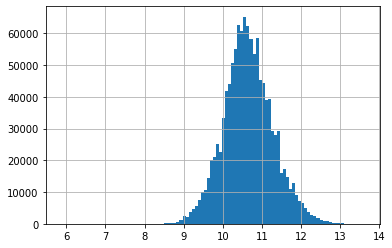

In [41]:
apart_trade_df['target_log_transformed'].hist(bins=100)

In [42]:
prac_df['target_log_transformed'].describe()

count    1.152728e+06
mean     1.064599e+01
std      5.983538e-01
min      9.024011e+00
25%      1.024708e+01
50%      1.062133e+01
75%      1.103489e+01
max      1.226700e+01
Name: target_log_transformed, dtype: float64

<AxesSubplot:>

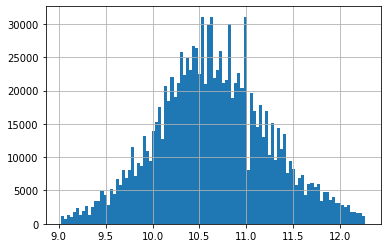

In [43]:
prac_df['target_log_transformed'].hist(bins=100)

In [44]:
apart_trade_df.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201309,8,57000,2,1988,언주로 103,733.118971,2013,9,서울특별시,강남구,10.950807
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201312,16,57000,2,1988,언주로 103,733.118971,2013,12,서울특별시,강남구,10.950807
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,11,55000,5,1987,언주로 3,817.479191,2013,2,서울특별시,강남구,10.915088
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,22,58250,4,1987,언주로 3,865.784780,2013,2,서울특별시,강남구,10.972499
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201305,10,60000,5,1987,언주로 3,891.795482,2013,5,서울특별시,강남구,11.002100


In [47]:
def show_target_log_hist_every_gu(df):
    df = df.copy()
    
    unique_gus = df['구'].unique()
    
    for gu in unique_gus:
        gu_df = df[df['구'] == gu]
        
        print(gu)
        display(gu_df['target_log_transformed'].hist(bins=100))
        plt.show()
        plt.clf()

강남구


<AxesSubplot:>

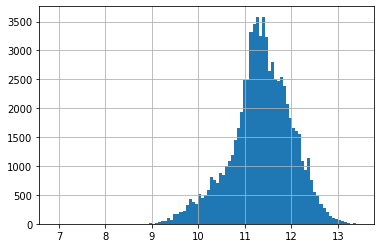

강동구


<AxesSubplot:>

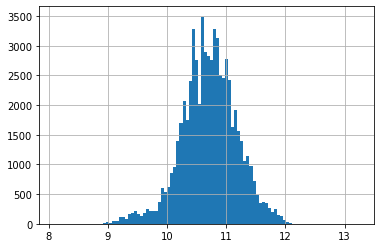

강북구


<AxesSubplot:>

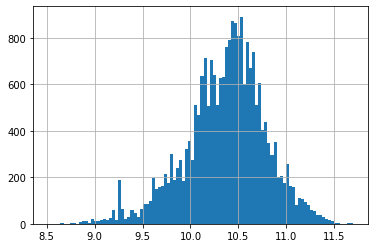

강서구


<AxesSubplot:>

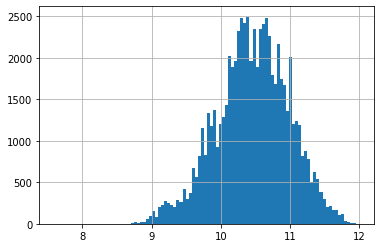

관악구


<AxesSubplot:>

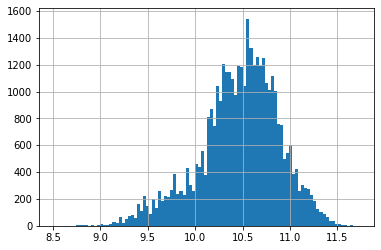

광진구


<AxesSubplot:>

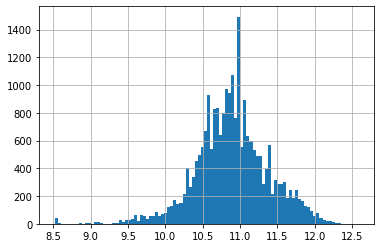

구로구


<AxesSubplot:>

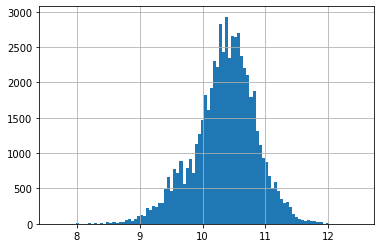

금천구


<AxesSubplot:>

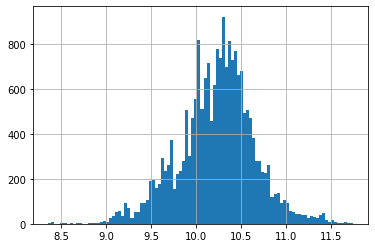

노원구


<AxesSubplot:>

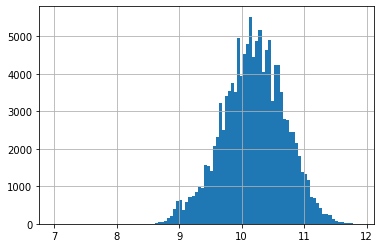

도봉구


<AxesSubplot:>

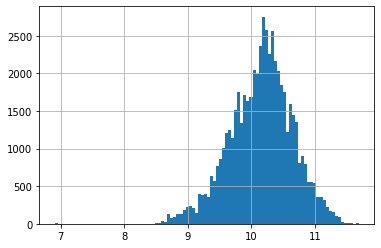

동대문구


<AxesSubplot:>

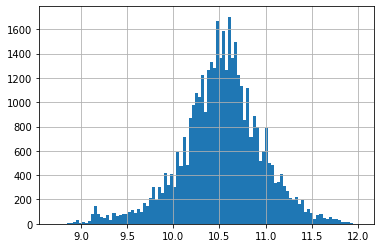

동작구


<AxesSubplot:>

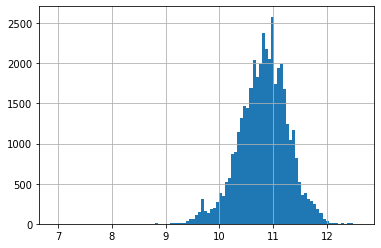

마포구


<AxesSubplot:>

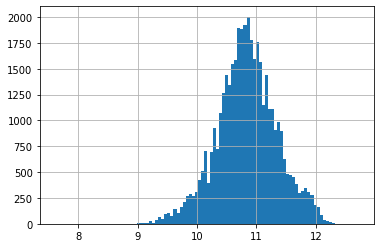

서대문구


<AxesSubplot:>

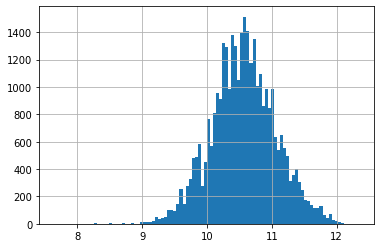

서초구


<AxesSubplot:>

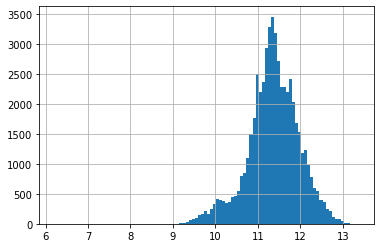

성동구


<AxesSubplot:>

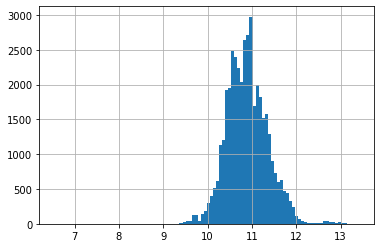

성북구


<AxesSubplot:>

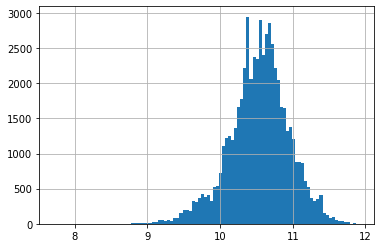

송파구


<AxesSubplot:>

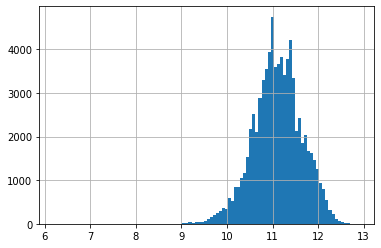

양천구


<AxesSubplot:>

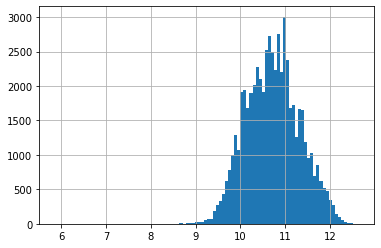

영등포구


<AxesSubplot:>

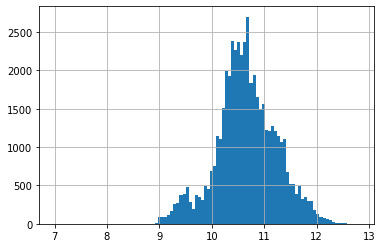

용산구


<AxesSubplot:>

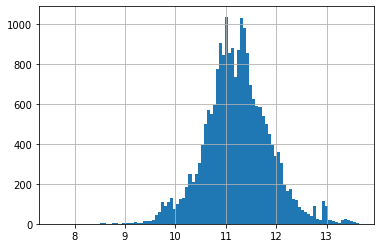

은평구


<AxesSubplot:>

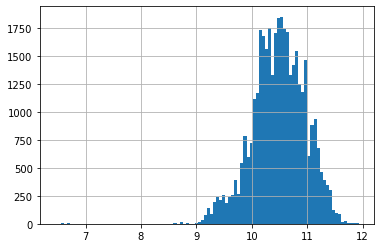

종로구


<AxesSubplot:>

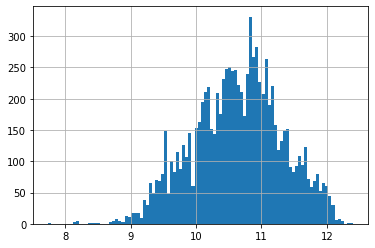

중구


<AxesSubplot:>

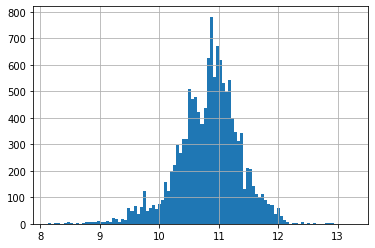

중랑구


<AxesSubplot:>

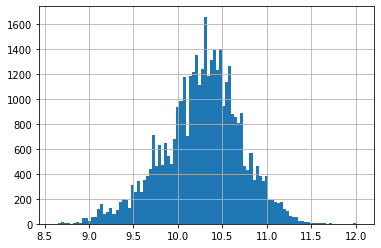

<Figure size 432x288 with 0 Axes>

In [48]:
show_target_log_hist_every_gu(apart_trade_df)

In [57]:
# Tukey의 기법을 사용하여 각 구 별 이상치 (outlier) 검색 후 제거 (가격)

def find_and_remove_Tukey_outliers_price_per_gu(df):
    df = df.copy()
    
    unique_gus = df['구'].unique()
    
    count = 0
    dfs_list = []
    for gu in unique_gus:
        gu_df = df[df['구'] == gu]
    
        q1 = gu_df['target_log_transformed'].quantile(0.25)
        q3 = gu_df['target_log_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = iqr * 1.5

        outlier_df = gu_df[(gu_df['target_log_transformed'] < q1 - outlier_step) | (gu_df['target_log_transformed'] > q3 + outlier_step)]

        gu_df.drop(outlier_df.index, inplace=True)
        
        dfs_list.append(gu_df)

        print('{}에서 {}개의 이상치를 찾아서 제거했습니다.'.format(gu, outlier_df.shape[0]))
        
        count += outlier_df.shape[0]
    
    print('총 {}개의 이상치를 찾아서 제거했습니다.'.format(count))
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)   
    
    return concat_df

In [51]:
prac_df = find_and_remove_Tukey_outliers_price_per_gu(apart_trade_df)

강남구에서 1694개의 이상치를 찾아서 제거했습니다.
강동구에서 1608개의 이상치를 찾아서 제거했습니다.
강북구에서 612개의 이상치를 찾아서 제거했습니다.
강서구에서 468개의 이상치를 찾아서 제거했습니다.
관악구에서 812개의 이상치를 찾아서 제거했습니다.
광진구에서 578개의 이상치를 찾아서 제거했습니다.
구로구에서 1367개의 이상치를 찾아서 제거했습니다.
금천구에서 730개의 이상치를 찾아서 제거했습니다.
노원구에서 356개의 이상치를 찾아서 제거했습니다.
도봉구에서 566개의 이상치를 찾아서 제거했습니다.
동대문구에서 1549개의 이상치를 찾아서 제거했습니다.
동작구에서 664개의 이상치를 찾아서 제거했습니다.
마포구에서 508개의 이상치를 찾아서 제거했습니다.
서대문구에서 320개의 이상치를 찾아서 제거했습니다.
서초구에서 1376개의 이상치를 찾아서 제거했습니다.
성동구에서 530개의 이상치를 찾아서 제거했습니다.
성북구에서 1358개의 이상치를 찾아서 제거했습니다.
송파구에서 886개의 이상치를 찾아서 제거했습니다.
양천구에서 96개의 이상치를 찾아서 제거했습니다.
영등포구에서 849개의 이상치를 찾아서 제거했습니다.
용산구에서 638개의 이상치를 찾아서 제거했습니다.
은평구에서 321개의 이상치를 찾아서 제거했습니다.
종로구에서 21개의 이상치를 찾아서 제거했습니다.
중구에서 347개의 이상치를 찾아서 제거했습니다.
중랑구에서 753개의 이상치를 찾아서 제거했습니다.
총 19007개의 이상치를 찾아서 제거했습니다.


<AxesSubplot:>

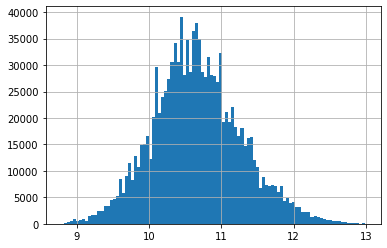

In [52]:
prac_df['target_log_transformed'].hist(bins=100)

<AxesSubplot:>

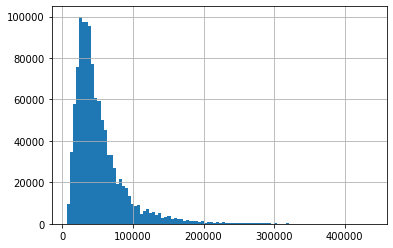

In [53]:
prac_df['거래금액(만원)'].hist(bins=100)

In [54]:
prac_df['거래금액(만원)'].describe()

count    1.149185e+06
mean     5.223752e+04
std      3.799491e+04
min      6.500000e+03
25%      2.870000e+04
50%      4.160000e+04
75%      6.300000e+04
max      4.380000e+05
Name: 거래금액(만원), dtype: float64

In [56]:
# Tukey의 기법을 사용하여 각 동 별 이상치 (outlier) 검색 후 제거 (가격)

def find_and_remove_Tukey_outliers_price_per_dong(df):
    df = df.copy()
    
    unique_dongs = df['시군구'].unique()
    
    count = 0
    dfs_list = []
    for dong in unique_dongs:
        dong_df = df[df['시군구'] == dong]
    
        q1 = dong_df['target_log_transformed'].quantile(0.25)
        q3 = dong_df['target_log_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = iqr * 1.5

        outlier_df = dong_df[(dong_df['target_log_transformed'] < q1 - outlier_step) | (dong_df['target_log_transformed'] > q3 + outlier_step)]

        dong_df.drop(outlier_df.index, inplace=True)
        
        dfs_list.append(dong_df)

        print('{}에서 {}개의 이상치를 찾아서 제거했습니다.'.format(dong, outlier_df.shape[0]))
        
        count += outlier_df.shape[0]
    
    print('총 {}개의 이상치를 찾아서 제거했습니다.'.format(count))
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)   
    
    return concat_df

In [58]:
prac_df = find_and_remove_Tukey_outliers_price_per_dong(apart_trade_df)

서울특별시 강남구 개포동에서 339개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 논현동에서 37개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 대치동에서 615개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 도곡동에서 364개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 삼성동에서 143개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 세곡동에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 수서동에서 11개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 신사동에서 55개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 압구정동에서 19개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 역삼동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 일원동에서 103개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 청담동에서 108개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 강일동에서 42개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 고덕동에서 75개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 길동에서 572개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 둔촌동에서 15개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 명일동에서 54개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 상일동에서 256개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 성내동에서 176개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 암사동에서 45개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 천호동에서 186개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 미아동에서 351개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 번동에서 91개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 수유동에서 59개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 우이동에서 5개의 이상치를 찾아서 제거했습니다.
서울특별시 강서구 가양동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 

서울특별시 영등포구 영등포동5가에서 15개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동7가에서 80개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동8가에서 60개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 도원동에서 46개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 동빙고동에서 5개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 동자동에서 54개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 문배동에서 138개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 보광동에서 29개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 산천동에서 2개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 서빙고동에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 신계동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 신창동에서 12개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용문동에서 9개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용산동2가에서 2개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용산동5가에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 원효로1가에서 16개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 원효로4가에서 10개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 이촌동에서 50개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 이태원동에서 27개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 청암동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 청파동1가에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로1가에서 6개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로2가에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로3가에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한남동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 효창동에서 8개의 이상치를 찾아서 제거

In [62]:
print(apart_trade_df.shape)
print(prac_df.shape)

(1168192, 18)
(1149236, 18)


In [59]:
prac_df['거래금액(만원)'].describe()

count    1.149236e+06
mean     5.234825e+04
std      3.924765e+04
min      2.300000e+03
25%      2.850000e+04
50%      4.150000e+04
75%      6.290000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

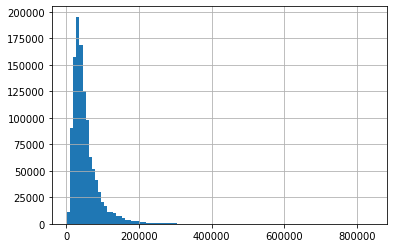

In [61]:
prac_df['거래금액(만원)'].hist(bins=100)

<AxesSubplot:>

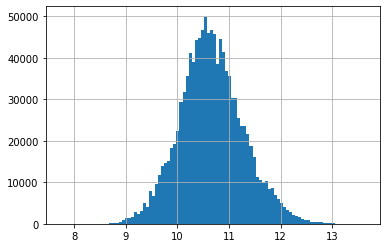

In [63]:
prac_df['target_log_transformed'].hist(bins=100)

In [64]:
min_df = prac_df[prac_df['거래금액(만원)'] == prac_df['거래금액(만원)'].min()]
min_df.shape

(1, 18)

In [65]:
min_df

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed
1148737,서울특별시 종로구 행촌동,41-1,41,1,대성맨션,19.27,200602,27,2300,1,1971,사직로 21,119.356513,2006,2,서울특별시,종로구,7.740664


In [66]:
min_addr_df = prac_df[prac_df['단지명'] == min_df['단지명'].iloc[0]]
min_addr_df.shape

(52, 18)

# 가격log/면적

In [71]:
apart_trade_df.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201309,8,57000,2,1988,언주로 103,733.118971,2013,9,서울특별시,강남구,10.950807,6.597308
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201312,16,57000,2,1988,언주로 103,733.118971,2013,12,서울특별시,강남구,10.950807,6.597308
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,11,55000,5,1987,언주로 3,817.479191,2013,2,서울특별시,강남구,10.915088,6.706225
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,22,58250,4,1987,언주로 3,865.784780,2013,2,서울특별시,강남구,10.972499,6.763636
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201305,10,60000,5,1987,언주로 3,891.795482,2013,5,서울특별시,강남구,11.002100,6.793237


In [72]:
apart_trade_df['가격log/면적'] = apart_trade_df['target_log_transformed'] / apart_trade_df['전용면적(㎡)']

In [73]:
apart_trade_df['가격log/면적'].describe()

count    1.168192e+06
mean     1.580686e-01
std      7.245738e-02
min      3.088762e-02
25%      1.238074e-01
50%      1.359105e-01
75%      1.778752e-01
max      9.738984e-01
Name: 가격log/면적, dtype: float64

<AxesSubplot:>

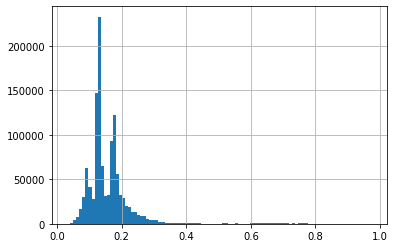

In [74]:
apart_trade_df['가격log/면적'].hist(bins=100)

# 가격/면적

<AxesSubplot:>

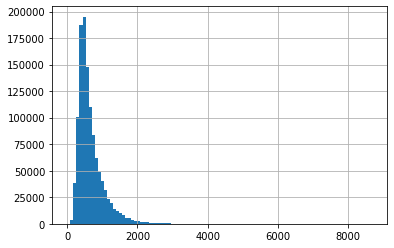

In [69]:
apart_trade_df['가격/면적'].hist(bins=100)

In [70]:
apart_trade_df['target/area_log_transformed'] = apart_trade_df['가격/면적'].apply(lambda x: np.log(x))
apart_lease_df['target/area_log_transformed'] = apart_lease_df['가격/면적'].apply(lambda x: np.log(x))
multiplex_trade_df['target/area_log_transformed'] = multiplex_trade_df['가격/면적'].apply(lambda x: np.log(x))
multiplex_lease_df['target/area_log_transformed'] = multiplex_lease_df['가격/면적'].apply(lambda x: np.log(x))
officetel_trade_df['target/area_log_transformed'] = officetel_trade_df['가격/면적'].apply(lambda x: np.log(x))
officetel_lease_df['target/area_log_transformed'] = officetel_lease_df['가격/면적'].apply(lambda x: np.log(x))

<AxesSubplot:>

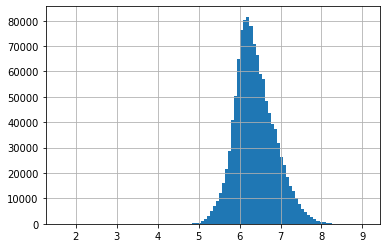

In [75]:
apart_trade_df['target/area_log_transformed'].hist(bins=100)

In [76]:
# Tukey의 기법을 사용하여 각 동 별 이상치 (outlier) 검색 후 제거 (가격/면적 log)

def find_and_remove_Tukey_outliers_price_per_area_log_per_dong(df):
    df = df.copy()
    
    unique_dongs = df['시군구'].unique()
    
    count = 0
    dfs_list = []
    for dong in unique_dongs:
        dong_df = df[df['시군구'] == dong]
    
        q1 = dong_df['target/area_log_transformed'].quantile(0.25)
        q3 = dong_df['target/area_log_transformed'].quantile(0.75)
        iqr = q3 - q1
        outlier_step = iqr * 1.5

        outlier_df = dong_df[(dong_df['target/area_log_transformed'] < q1 - outlier_step) |\
                             (dong_df['target/area_log_transformed'] > q3 + outlier_step)]

        dong_df.drop(outlier_df.index, inplace=True)
        
        dfs_list.append(dong_df)

        print('{}에서 {}개의 이상치를 찾아서 제거했습니다.'.format(dong, outlier_df.shape[0]))
        
        count += outlier_df.shape[0]
    
    print('총 {}개의 이상치를 찾아서 제거했습니다.'.format(count))
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)   
    
    return concat_df

In [77]:
prac_df = find_and_remove_Tukey_outliers_price_per_area_log_per_dong(apart_trade_df)

서울특별시 강남구 개포동에서 288개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 논현동에서 63개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 대치동에서 660개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 도곡동에서 145개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 삼성동에서 68개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 세곡동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 수서동에서 77개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 신사동에서 6개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 압구정동에서 56개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 역삼동에서 15개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 일원동에서 386개의 이상치를 찾아서 제거했습니다.
서울특별시 강남구 청담동에서 114개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 강일동에서 31개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 고덕동에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 길동에서 141개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 둔촌동에서 42개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 명일동에서 373개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 상일동에서 142개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 성내동에서 146개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 암사동에서 538개의 이상치를 찾아서 제거했습니다.
서울특별시 강동구 천호동에서 341개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 미아동에서 256개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 번동에서 298개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 수유동에서 136개의 이상치를 찾아서 제거했습니다.
서울특별시 강북구 우이동에서 4개의 이상치를 찾아서 제거했습니다.
서울특별시 강서구 가양동에서 288개의 이상치를 찾아서 제거했습니다.
서울

서울특별시 영등포구 영등포동1가에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동2가에서 6개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동4가에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동5가에서 1개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동7가에서 93개의 이상치를 찾아서 제거했습니다.
서울특별시 영등포구 영등포동8가에서 28개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 도원동에서 170개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 동빙고동에서 4개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 동자동에서 17개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 문배동에서 4개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 보광동에서 26개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 산천동에서 108개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 서빙고동에서 33개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 신계동에서 30개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 신창동에서 13개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용문동에서 20개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용산동2가에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 용산동5가에서 1개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 원효로1가에서 7개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 원효로4가에서 24개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 이촌동에서 334개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 이태원동에서 37개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 청암동에서 3개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 청파동1가에서 0개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로1가에서 12개의 이상치를 찾아서 제거했습니다.
서울특별시 용산구 한강로2가에서 4

<AxesSubplot:>

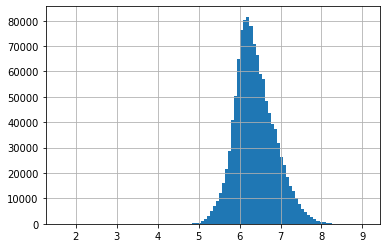

In [78]:
apart_trade_df['target/area_log_transformed'].hist(bins=100)

<AxesSubplot:>

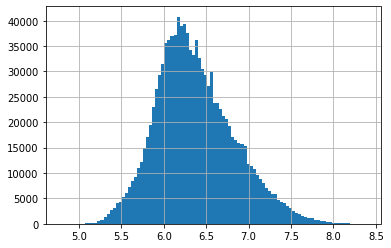

In [79]:
prac_df['target/area_log_transformed'].hist(bins=100)

In [80]:
apart_trade_df['거래금액(만원)'].describe()

count    1.168192e+06
mean     5.231642e+04
std      4.018041e+04
min      3.500000e+02
25%      2.800000e+04
50%      4.130000e+04
75%      6.300000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

In [81]:
prac_df['거래금액(만원)'].describe()

count    1.130131e+06
mean     5.189409e+04
std      3.935123e+04
min      3.400000e+03
25%      2.840000e+04
50%      4.100000e+04
75%      6.200000e+04
max      8.400000e+05
Name: 거래금액(만원), dtype: float64

<AxesSubplot:>

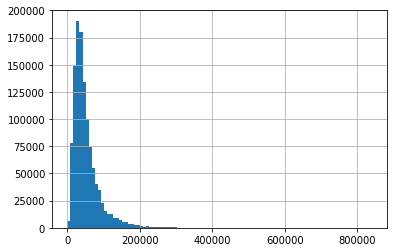

In [82]:
apart_trade_df['거래금액(만원)'].hist(bins=100)

<AxesSubplot:>

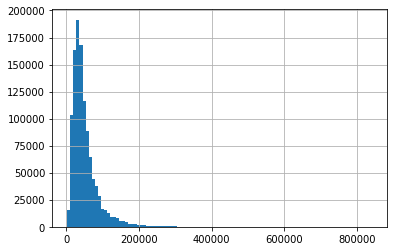

In [83]:
prac_df['거래금액(만원)'].hist(bins=100)

In [84]:
apart_trade_df.head()

,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,가격/면적,year,month,시,구,target_log_transformed,target/area_log_transformed,가격log/면적
0,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201309,8,57000,2,1988,언주로 103,733.118971,2013,9,서울특별시,강남구,10.950807,6.597308,0.140846
1,서울특별시 강남구 개포동,655-2,655,2,개포2차현대아파트(220),77.75,201312,16,57000,2,1988,언주로 103,733.118971,2013,12,서울특별시,강남구,10.950807,6.597308,0.140846
2,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,11,55000,5,1987,언주로 3,817.479191,2013,2,서울특별시,강남구,10.915088,6.706225,0.162234
3,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201302,22,58250,4,1987,언주로 3,865.784780,2013,2,서울특별시,강남구,10.972499,6.763636,0.163087
4,서울특별시 강남구 개포동,658-1,658,1,개포6차우성아파트1동~8동,67.28,201305,10,60000,5,1987,언주로 3,891.795482,2013,5,서울특별시,강남구,11.002100,6.793237,0.163527


In [ ]:
apart_trade_df = find_and_remove_Tukey_outliers_price(apart_trade_df)
multiplex_trade_df = find_and_remove_Tukey_outliers_price(multiplex_trade_df)
officetel_trade_df = find_and_remove_Tukey_outliers_price(officetel_trade_df)

In [ ]:
apart_lease_deposit_only_df = find_and_remove_Tukey_outliers_price(apart_lease_deposit_only_df, mode='lease')
apart_lease_monthly_pay_df = find_and_remove_Tukey_outliers_price(apart_lease_monthly_pay_df, mode='lease')
multiplex_lease_deposit_only_df = find_and_remove_Tukey_outliers_price(multiplex_lease_deposit_only_df, mode='lease')
multiplex_lease_monthly_pay_df = find_and_remove_Tukey_outliers_price(multiplex_lease_monthly_pay_df, mode='lease')
officetel_lease_deposit_only_df = find_and_remove_Tukey_outliers_price(officetel_lease_deposit_only_df, mode='lease')
officetel_lease_monthly_pay_df = find_and_remove_Tukey_outliers_price(officetel_lease_monthly_pay_df, mode='lease')